# Imports

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from tqdm import tqdm
from glob import glob
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
import tensorflow.lite as tflite


# Data Preparation

In [ ]:
# Constants
RTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\RTM_images'
DTM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\DTM_images'
ATM_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\ATM_images'
SOR_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_SOR'
SOT_PATH = r'\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_SOT'
var_2d = r'\\VS Projects\\ML-on-Microcontrollers-Project-Ioana-Gidiuta\\Datasets\\11G-features\\Signal_Variation_2D'

IMG_SIZE = (32, 32)
SEQ_LEN = 5

In [37]:
def load_and_resize_image(path):
    img = load_img(path, color_mode='grayscale', target_size=IMG_SIZE)
    return img_to_array(img).astype(np.uint8)

def load_npy_feature(path):
    try:
        arr = np.load(path)
        arr = np.resize(arr, IMG_SIZE)
        return arr[:, :, np.newaxis].astype(np.uint8)  # (32, 32, 1)
    except Exception as e:
        print(f"Error loading npy file: {path}, {e}")
        return np.zeros((*IMG_SIZE, 1), dtype=np.uint8)

In [39]:
def index_multi_image_sequences(rtm_path, dtm_path, atm_path, sor_path, sot_path, var2d_path, seq_len=5, exclude_participants=None):
    all_train_samples, test_samples = [], []
    gesture_set = set()
    exclude_participants = set(exclude_participants or [])

    participants = sorted([p for p in os.listdir(rtm_path) if os.path.isdir(os.path.join(rtm_path, p))])  

    for person in participants:
        is_test_person = person in exclude_participants
        rtm_person_path = os.path.join(rtm_path, person)

        for session in os.listdir(rtm_person_path):
            rtm_sess_path = os.path.join(rtm_person_path, session)
            if not os.path.isdir(rtm_sess_path):
                continue

            for gesture in os.listdir(rtm_sess_path):
                # Construct paths for all 6 modalities
                rtm_gesture_path = os.path.join(rtm_sess_path, gesture)
                dtm_gesture_path = os.path.join(dtm_path, person, session, gesture)
                atm_gesture_path = os.path.join(atm_path, person, session, gesture)
                sor_gesture_path = os.path.join(sor_path, person, session, gesture)
                sot_gesture_path = os.path.join(sot_path, person, session, gesture)
                var2d_gesture_path = os.path.join(var2d_path, person, session, gesture)

                if not all(map(os.path.isdir, [
                    rtm_gesture_path, dtm_gesture_path, atm_gesture_path,
                    sor_gesture_path, sot_gesture_path, var2d_gesture_path
                ])):
                    continue

                gesture_set.add(gesture)

                # Load and sort files for each modality
                rtm_files = sorted(glob(os.path.join(rtm_gesture_path, '*.png')))
                dtm_files = sorted(glob(os.path.join(dtm_gesture_path, '*.png')))
                atm_files = sorted(glob(os.path.join(atm_gesture_path, '*.png')))
                sor_files = sorted(glob(os.path.join(sor_gesture_path, '*.npy')))
                sot_files = sorted(glob(os.path.join(sot_gesture_path, '*.npy')))
                var2d_files = sorted(glob(os.path.join(var2d_gesture_path, '*.npy')))

                num_frames = min(
                    len(rtm_files), len(dtm_files), len(atm_files),
                    len(sor_files), len(sot_files), len(var2d_files)
                )

                for i in range(num_frames - seq_len + 1):
                    sample = {
                        'rtm': rtm_files[i:i+seq_len],
                        'dtm': dtm_files[i:i+seq_len],
                        'atm': atm_files[i:i+seq_len],
                        'sor': sor_files[i:i+seq_len],
                        'sot': sot_files[i:i+seq_len],
                        'var2d': var2d_files[i:i+seq_len],
                        'label': gesture
                    }

                    if is_test_person:
                        test_samples.append(sample)
                    else:
                        all_train_samples.append(sample)

    # Train/val split
    train_samples, val_samples = train_test_split(
        all_train_samples, test_size=0.2, random_state=42, shuffle=True
    )

    label_map = {gesture: idx for idx, gesture in enumerate(sorted(gesture_set))}
    return train_samples, val_samples, test_samples, label_map


In [40]:
class MultiRadarSequenceGenerator(Sequence):
    def __init__(self, samples, label_map, batch_size=32, seq_len=SEQ_LEN, shuffle_data=False):
        self.samples = samples
        self.label_map = label_map
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.shuffle_data = shuffle_data
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch_samples = self.samples[index * self.batch_size:(index + 1) * self.batch_size]
        X_rtm, X_dtm, X_atm, X_sor, X_sot, X_var2d, y = self.__load_batch(batch_samples)
        return [X_rtm, X_dtm, X_atm, X_sor, X_sot, X_var2d], y

    def on_epoch_end(self):
        if self.shuffle_data:
            self.samples = shuffle(self.samples)

    def __load_batch(self, batch_samples):
        X_rtm, X_dtm, X_atm = [], [], []
        X_sor, X_sot, X_var2d = [], [], []
        y = []

        for sample in batch_samples:
            try:
                rtm_seq = [load_and_resize_image(p) for p in sample['rtm']]
                dtm_seq = [load_and_resize_image(p) for p in sample['dtm']]
                atm_seq = [load_and_resize_image(p) for p in sample['atm']]
                sor_seq = [load_npy_feature(p) for p in sample['sor']]
                sot_seq = [load_npy_feature(p) for p in sample['sot']]
                var2d_seq = [load_npy_feature(p) for p in sample['var2d']]

                if len(rtm_seq) == self.seq_len:
                    X_rtm.append(rtm_seq)
                    X_dtm.append(dtm_seq)
                    X_atm.append(atm_seq)
                    X_sor.append(sor_seq)
                    X_sot.append(sot_seq)
                    X_var2d.append(var2d_seq)
                    y.append(self.label_map[sample['label']])
            except Exception as e:
                print(f"Error loading sample: {e}")

        return (
            np.array(X_rtm),
            np.array(X_dtm),
            np.array(X_atm),
            np.array(X_sor),
            np.array(X_sot),
            np.array(X_var2d),
            np.array(y)
        )


In [41]:
excluded = {f'p0_{i}' for i in range(15, 21)}
train_samples, val_samples, test_samples, label_map = index_multi_image_sequences(
    RTM_PATH, DTM_PATH, ATM_PATH, SOR_PATH, SOT_PATH, var_2d,
    seq_len=SEQ_LEN,
    exclude_participants=excluded
)

train_gen = MultiRadarSequenceGenerator(train_samples, label_map, batch_size=32, shuffle_data=True)
val_gen = MultiRadarSequenceGenerator(val_samples, label_map, batch_size=32)
test_gen = MultiRadarSequenceGenerator(test_samples, label_map, batch_size=32)

In [42]:
with open("validation_inputs.txt", "w") as in_f, open("validation_outputs.txt", "w") as out_f:
    for X_batch, y_batch in test_gen:
        batch_size = len(y_batch)
        for i in range(batch_size):
            # Write 6 lines for 6 input modalities
            for j in range(6):
                # Flatten the (5, 32, 32, 1) array to 1D
                flattened = X_batch[j][i].astype(np.float32).flatten()
                line = " ".join(map(str, flattened))
                in_f.write(line + "\n")

            # Write corresponding output label
            out_f.write(str(int(y_batch[i])) + "\n")

In [16]:
print(f"Training samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")
print(f"Test samples: {len(test_samples)}")

batch = train_gen[0][0]
print(f"Input shapes:")
print(f"  RTM: {batch[0].shape}")
print(f"  DTM: {batch[1].shape}")
print(f"  ATM: {batch[2].shape}")
print(f"  SOR: {batch[3].shape}")
print(f"  SOT: {batch[4].shape}")
print(f"  VAR2D: {batch[5].shape}")


Training samples: 6489
Validation samples: 1623
Test samples: 1166
Input shapes:
  RTM: (32, 5, 32, 32, 1)
  DTM: (32, 5, 32, 32, 1)
  ATM: (32, 5, 32, 32, 1)
  SOR: (32, 5, 32, 32, 1)
  SOT: (32, 5, 32, 32, 1)
  VAR2D: (32, 5, 32, 32, 1)


# Model

In [17]:
def build_compact_cnn(input_shape=(32, 32, 1)):
    input_layer = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.DepthwiseConv2D(3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inputs=input_layer, outputs=x)

def build_small_multi_cnn_lstm(seq_len=5, img_shape=(32, 32, 1), num_classes=11):
    # Define 6 input layers
    rtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="rtm_input")
    dtm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="dtm_input")
    atm_input = tf.keras.Input(shape=(seq_len, *img_shape), name="atm_input")
    sor_input = tf.keras.Input(shape=(seq_len, *img_shape), name="sor_input")
    sot_input = tf.keras.Input(shape=(seq_len, *img_shape), name="sot_input")
    var2d_input = tf.keras.Input(shape=(seq_len, *img_shape), name="var2d_input")

    # Shared CNN encoder
    cnn_encoder = build_compact_cnn(img_shape)

    # Apply TimeDistributed CNN to each input
    encoded = [
        layers.TimeDistributed(cnn_encoder)(inp)
        for inp in [rtm_input, dtm_input, atm_input, sor_input, sot_input, var2d_input]
    ]

    merged = layers.Concatenate(axis=-1)(encoded)

    x = layers.LSTM(32, return_sequences=False)(merged)

    output = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(
        inputs=[rtm_input, dtm_input, atm_input, sor_input, sot_input, var2d_input],
        outputs=output
    )

# Traning and Validation

In [10]:
class BatchCheckpoint(Callback):
    def __init__(self, save_dir, label_map, every_n_batches=100):
        super().__init__()
        self.save_dir = save_dir
        self.every_n_batches = every_n_batches
        self.batch_count = 0
        self.label_map = label_map
        os.makedirs(save_dir, exist_ok=True)

    def on_train_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.every_n_batches == 0:
            filename = os.path.join(self.save_dir, f"batch_{self.batch_count:06d}.h5")
            self.model.save(filename, save_format="tf")
            print(f"Saved model at batch {self.batch_count} to {filename}")

class TQDMProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_gen):
        super().__init__()
        self.test_gen = test_gen

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_pbar = tqdm(total=1, desc=f"Epoch {epoch+1}", unit="epoch")

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_pbar.update(1)
        self.epoch_pbar.close()
        loss, acc = self.model.evaluate(self.test_gen, verbose=0)
        print(f"Epoch {epoch+1}: Test Accuracy = {acc:.4f}")
                    
class SaveLossAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, filepath='training_log.txt'):
        super().__init__()
        self.filepath = filepath
        with open(self.filepath, 'w') as f:
            f.write("epoch,loss,accuracy,val_loss,val_accuracy\n")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        line = f"{epoch+1},{logs.get('loss'):.4f},{logs.get('accuracy'):.4f},{logs.get('val_loss'):.4f},{logs.get('val_accuracy'):.4f}\n"
        with open(self.filepath, 'a') as f:
            f.write(line)

In [ ]:
model = build_small_multi_cnn_lstm(num_classes=len(label_map))

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = ModelCheckpoint(
    filepath='Models/3_radar_CNN_v2_var/qat_small_model_epoch{epoch:02d}_valacc{val_accuracy:.4f}.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

batch_checkpoint_cb = BatchCheckpoint(
    save_dir='Models/3_radar_CNN_v2_var/qat_batch_checkpoints',
    label_map=label_map,
    every_n_batches=2500
)

log_callback = SaveLossAccuracy(r"\Code\model_training\Models\3_radar_CNN_v2_var\qat_training_log.txt")

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, 
    callbacks=[
        TQDMProgressCallback(val_gen),
        checkpoint_cb,
        batch_checkpoint_cb,
        log_callback
    ],
    workers=1,
    use_multiprocessing=False,
)
model.save("Models/3_radar_CNN_v2_var/final_training_model.h5", save_format="tf")

# Testing

In [12]:
model.summary()
# i wanna know the size in mb
model_size = model.count_params() * 4 / (1024 * 1024)  # Assuming 4 bytes per float32
print(f"Model size: {model_size:.4f} MB")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 dtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 atm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                         

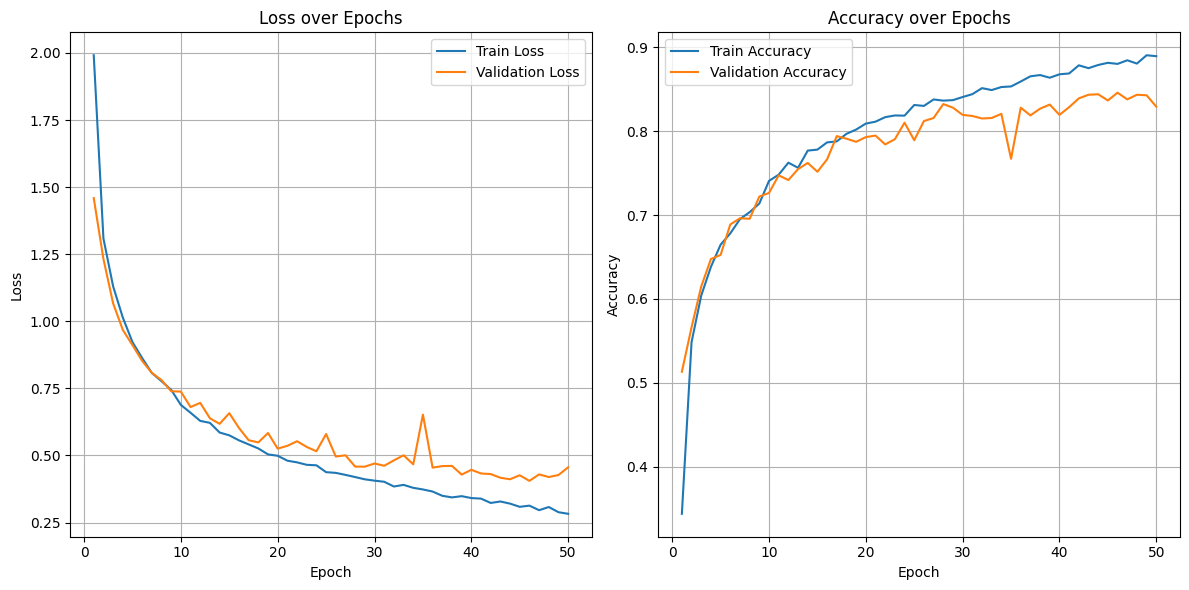

In [ ]:
# Load the training log
log_df = pd.read_csv(r"\Code\model_training\Models\3_radar_CNN_v2_var\qat_training_log.txt")#, sep="\t")

# Plot
if 'epoch' not in log_df.columns:
    log_df['epoch'] = range(1, len(log_df) + 1)

# Plot
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(log_df['epoch'], log_df['loss'], label='Train Loss')
plt.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(log_df['epoch'], log_df['accuracy'], label='Train Accuracy')
plt.plot(log_df['epoch'], log_df['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [27]:
def plot_confusion_matrix(y_true, y_pred, label_map, title_suffix=""):
    """
    Plots a normalized confusion matrix
    """
    # Invert label_map: index -> gesture name
    inv_label_map = {v: k for k, v in label_map.items()}
    gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

    # Compute and normalize confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=gesture_names, yticklabels=gesture_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix (%)\n{title_suffix}'.strip())
    plt.tight_layout()
    plt.show()


def print_classification_report(y_true, y_pred, label_map):
    """
    Prints a formatted classification report
    """
    inv_label_map = {v: k for k, v in label_map.items()}
    gesture_names = [inv_label_map[i] for i in sorted(inv_label_map)]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=gesture_names,
                                digits=4))


In [ ]:
model_path = "\Code\model_training\Models\3_radar_CNN_v2_var\qat_small_model_epoch46_valacc0.8460.h5"
model = tf.keras.models.load_model(
    model_path,
    custom_objects={
        'QuantizeAnnotate': quantize_annotate_layer,
        'quantize_annotate_layer': quantize_annotate_layer
    }
)

# Evaluate full model
test_loss, test_acc = model.evaluate(test_gen)
print(f"QAT Model Test Accuracy: {test_acc:.4f}")

37/37 [==============================] - 73s 2s/step - loss: 0.3769 - accuracy: 0.8568
QAT Model Test Accuracy: 0.8568


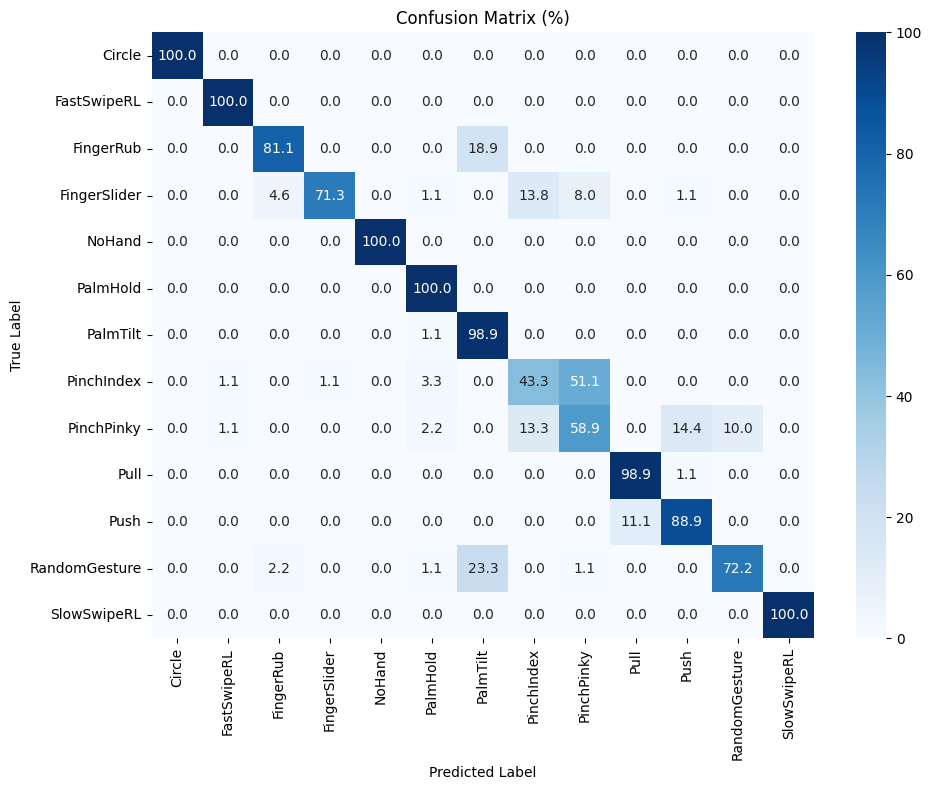


Classification Report:
               precision    recall  f1-score   support

       Circle     1.0000    1.0000    1.0000        90
  FastSwipeRL     0.9783    1.0000    0.9890        90
    FingerRub     0.9241    0.8111    0.8639        90
 FingerSlider     0.9841    0.7126    0.8267        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.9175    1.0000    0.9570        89
     PalmTilt     0.7008    0.9889    0.8203        90
   PinchIndex     0.6190    0.4333    0.5098        90
   PinchPinky     0.4953    0.5889    0.5381        90
         Pull     0.8990    0.9889    0.9418        90
         Push     0.8421    0.8889    0.8649        90
RandomGesture     0.8784    0.7222    0.7927        90
  SlowSwipeRL     1.0000    1.0000    1.0000        90

     accuracy                         0.8568      1166
    macro avg     0.8645    0.8565    0.8542      1166
 weighted avg     0.8642    0.8568    0.8541      1166



In [17]:
y_true = []
y_pred = []

for X, y in test_gen:
    preds = model.predict(X, verbose=0)
    y_true.extend(y)
    y_pred.extend(np.argmax(preds, axis=1))

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate and plot confusion matrix
plot_confusion_matrix(y_true, y_pred, label_map)
print_classification_report(y_true, y_pred, label_map)

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [19]:
y_true = []
y_probs = []

for batch_x, batch_y in test_gen:
    probs = model.predict(batch_x, verbose=0)
    y_probs.extend(probs)
    y_true.extend(batch_y)

y_true = np.array(y_true)
y_probs = np.array(y_probs)
# Binarize the labels for multi-class ROC
n_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

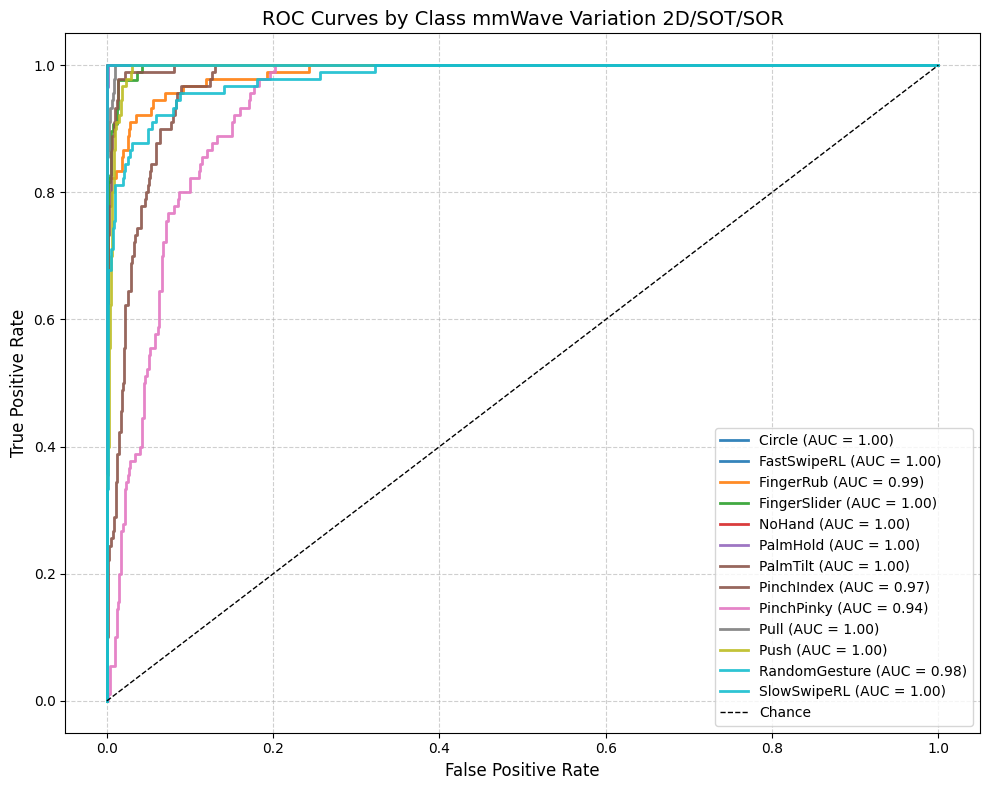

In [20]:
idx_to_class = {v: k for k, v in label_map.items()}
# Compute ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Use a colormap for distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, n_classes))

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f"{idx_to_class[i]} (AUC = {roc_auc[i]:.2f})",
             linewidth=2, alpha=0.9)

# Diagonal reference
plt.plot([0, 1], [0, 1], 'k--', label='Chance', linewidth=1)

# Plot aesthetics
plt.title("ROC Curves by Class mmWave Variation 2D/SOT/SOR", fontsize=14)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 rtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 dtm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 atm_input (InputLayer)         [(None, 5, 32, 32,   0           []                               
                                1)]                                                         

# Coverting to TFLite

In [ ]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # rtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # dtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # atm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sor
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sot
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # var2d
])
def wrapped_model(rtm, dtm, atm, sor, sot, var2d):
    return model([rtm, dtm, atm, sor, sot, var2d])

# Get concrete function
concrete_func = wrapped_model.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
tflite_model_fp16 = converter.convert()

with open("mmWave_v2_var_float32.tflite", "wb") as f:
    f.write(tflite_model_fp16)
print("Saved: mmWave_v2_var_float32.tflite")

In [32]:
interpreter = tf.lite.Interpreter(model_path="mmWave_v2_var_float32.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [33]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = len(y_batch)

    for i in range(batch_size):
        input_data = [
            X_batch[0][i:i+1],  # rtm
            X_batch[1][i:i+1],  # dtm
            X_batch[2][i:i+1],  # atm
            X_batch[3][i:i+1],  # sor
            X_batch[4][i:i+1],  # sot
            X_batch[5][i:i+1],  # var2d
        ]

        # Set inputs
        for j, input_tensor in enumerate(input_details):
            input_val = input_data[j].astype(np.float32)
            interpreter.set_tensor(input_tensor['index'], input_val)

        # Run inference
        interpreter.invoke()

        # Get predicted class
        output = interpreter.get_tensor(output_details[0]['index'])  
        predicted_class = int(np.argmax(output[0]))

        y_true.append(int(y_batch[i]))
        y_pred.append(predicted_class)

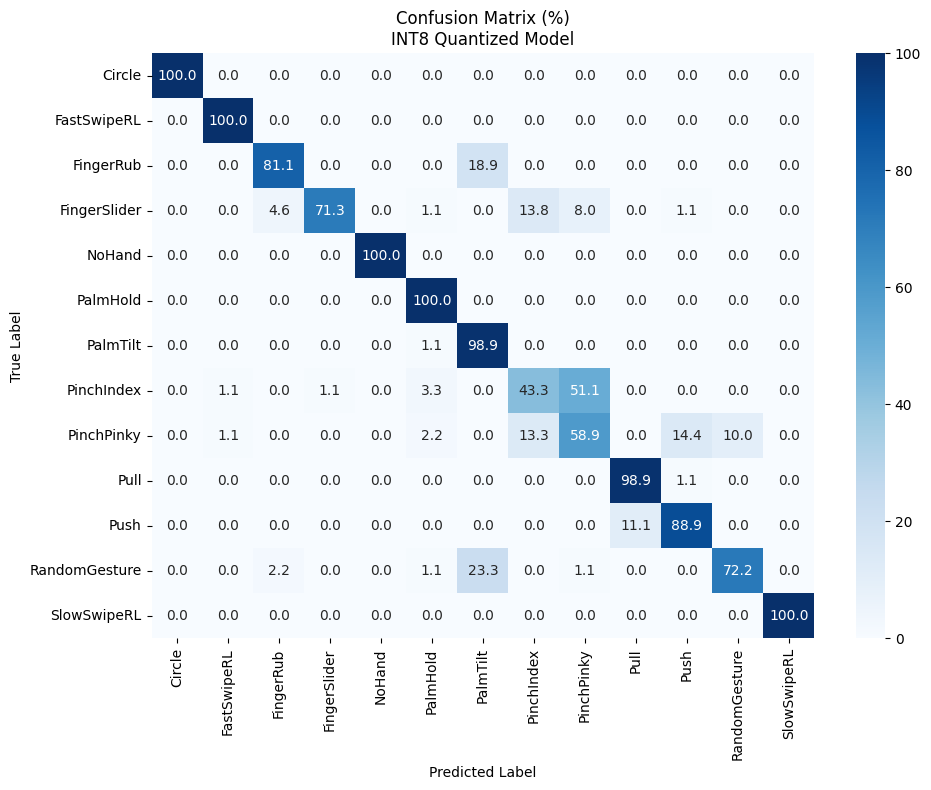


Classification Report:
               precision    recall  f1-score   support

       Circle     1.0000    1.0000    1.0000        90
  FastSwipeRL     0.9783    1.0000    0.9890        90
    FingerRub     0.9241    0.8111    0.8639        90
 FingerSlider     0.9841    0.7126    0.8267        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.9175    1.0000    0.9570        89
     PalmTilt     0.7008    0.9889    0.8203        90
   PinchIndex     0.6190    0.4333    0.5098        90
   PinchPinky     0.4953    0.5889    0.5381        90
         Pull     0.8990    0.9889    0.9418        90
         Push     0.8421    0.8889    0.8649        90
RandomGesture     0.8784    0.7222    0.7927        90
  SlowSwipeRL     1.0000    1.0000    1.0000        90

     accuracy                         0.8568      1166
    macro avg     0.8645    0.8565    0.8542      1166
 weighted avg     0.8642    0.8568    0.8541      1166



In [34]:
plot_confusion_matrix(y_true, y_pred, label_map, title_suffix="INT8 Quantized Model")
print_classification_report(y_true, y_pred, label_map)

# Quantizing to float 16

In [ ]:
# Wrap in tf.function with correct shape signature (batch=1)
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # rtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # dtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # atm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sor
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sot
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # var2d
])
def wrapped_model(rtm, dtm, atm, sor, sot, var2d):
    return model([rtm, dtm, atm, sor, sot, var2d])

# Get concrete function
concrete_func = wrapped_model.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
tflite_model_fp16 = converter.convert()

with open("mmWave_v2_var_float16.tflite", "wb") as f:
    f.write(tflite_model_fp16)
print("Saved: mmWave_v2_var_float16.tflite")

In [29]:
interpreter = tf.lite.Interpreter(model_path="mmWave_v2_var_float16.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = len(y_batch)

    for i in range(batch_size):
        input_data = [
            X_batch[0][i:i+1],  # rtm
            X_batch[1][i:i+1],  # dtm
            X_batch[2][i:i+1],  # atm
            X_batch[3][i:i+1],  # sor
            X_batch[4][i:i+1],  # sot
            X_batch[5][i:i+1],  # var2d
        ]

        # Set inputs
        for j, input_tensor in enumerate(input_details):
            input_val = input_data[j].astype(np.float32)
            interpreter.set_tensor(input_tensor['index'], input_val)

        # Run inference
        interpreter.invoke()

        # Get predicted class
        output = interpreter.get_tensor(output_details[0]['index'])  # shape: (1, num_classes)
        predicted_class = int(np.argmax(output[0]))

        y_true.append(int(y_batch[i]))
        y_pred.append(predicted_class)

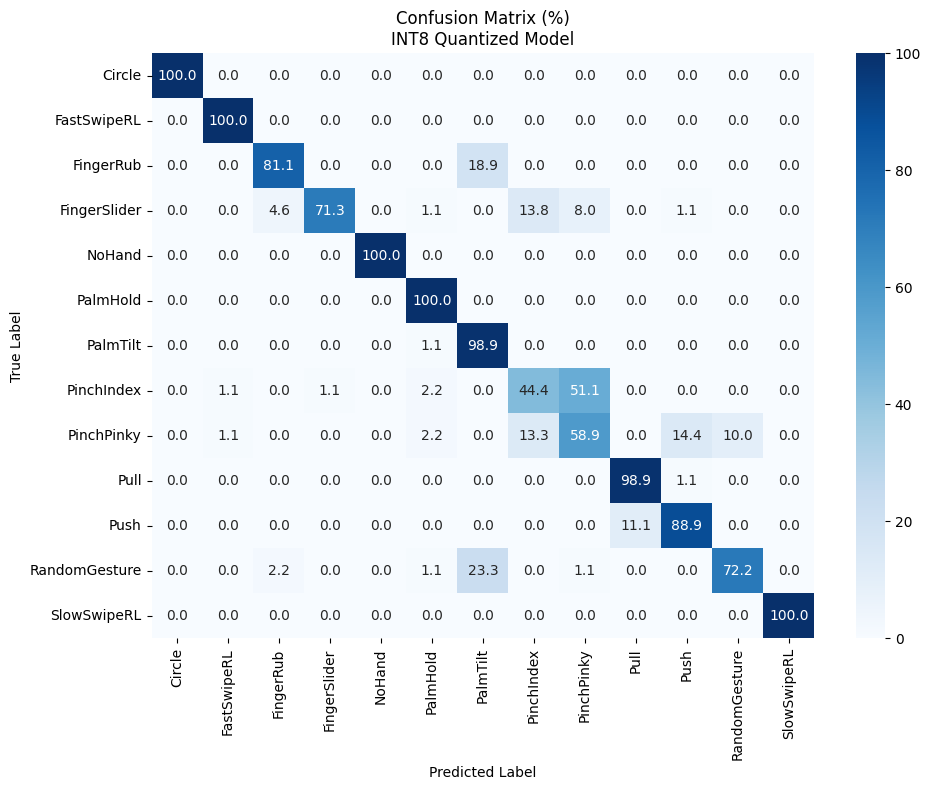


Classification Report:
               precision    recall  f1-score   support

       Circle     1.0000    1.0000    1.0000        90
  FastSwipeRL     0.9783    1.0000    0.9890        90
    FingerRub     0.9241    0.8111    0.8639        90
 FingerSlider     0.9841    0.7126    0.8267        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.9271    1.0000    0.9622        89
     PalmTilt     0.7008    0.9889    0.8203        90
   PinchIndex     0.6250    0.4444    0.5195        90
   PinchPinky     0.4953    0.5889    0.5381        90
         Pull     0.8990    0.9889    0.9418        90
         Push     0.8421    0.8889    0.8649        90
RandomGesture     0.8784    0.7222    0.7927        90
  SlowSwipeRL     1.0000    1.0000    1.0000        90

     accuracy                         0.8576      1166
    macro avg     0.8657    0.8574    0.8553      1166
 weighted avg     0.8653    0.8576    0.8553      1166



In [31]:
plot_confusion_matrix(y_true, y_pred, label_map, title_suffix="INT8 Quantized Model")
print_classification_report(y_true, y_pred, label_map)

# Quantizing to int8

In [19]:
def representative_dataset():
    for X_batch, _ in test_gen:
        for i in range(min(len(X_batch[0]), 100)):  # Limit to 100 samples
            yield [
                X_batch[0][i:i+1].astype(np.float32),  # rtm
                X_batch[1][i:i+1].astype(np.float32),  # dtm
                X_batch[2][i:i+1].astype(np.float32),  # atm
                X_batch[3][i:i+1].astype(np.float32),  # sor
                X_batch[4][i:i+1].astype(np.float32),  # sot
                X_batch[5][i:i+1].astype(np.float32),  # var2d
            ]

In [20]:
@tf.function(input_signature=[
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # rtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # dtm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # atm
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sor
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # sot
    tf.TensorSpec(shape=[1, 5, 32, 32, 1], dtype=tf.float32),  # var2d
])
def wrapped_model(rtm, dtm, atm, sor, sot, var2d):
    return model([rtm, dtm, atm, sor, sot, var2d])

# Get concrete function
concrete_func = wrapped_model.get_concrete_function()

In [ ]:
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

# These are essential for LSTM
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Optionally keep float32 I/O for easier use
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Convert
tflite_model_int8 = converter.convert()

# Save model
with open("mmWave_v2_var_int8.tflite", "wb") as f:
    f.write(tflite_model_int8)

print("Saved mmWave_v2_var_int8.tflite")

In [22]:
interpreter = tf.lite.Interpreter(model_path="mmWave_v2_var_int8.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [25]:
y_true = []
y_pred = []

for X_batch, y_batch in test_gen:
    batch_size = len(y_batch)

    for i in range(batch_size):
        input_data = [
            X_batch[0][i:i+1],  # rtm
            X_batch[1][i:i+1],  # dtm
            X_batch[2][i:i+1],  # atm
            X_batch[3][i:i+1],  # sor
            X_batch[4][i:i+1],  # sot
            X_batch[5][i:i+1],  # var2d
        ]

        # Set inputs
        for j, input_tensor in enumerate(input_details):
            input_val = input_data[j].astype(np.float32)
            interpreter.set_tensor(input_tensor['index'], input_val)

        # Run inference
        interpreter.invoke()

        # Get predicted class
        output = interpreter.get_tensor(output_details[0]['index'])  # shape: (1, num_classes)
        predicted_class = int(np.argmax(output[0]))

        y_true.append(int(y_batch[i]))
        y_pred.append(predicted_class)


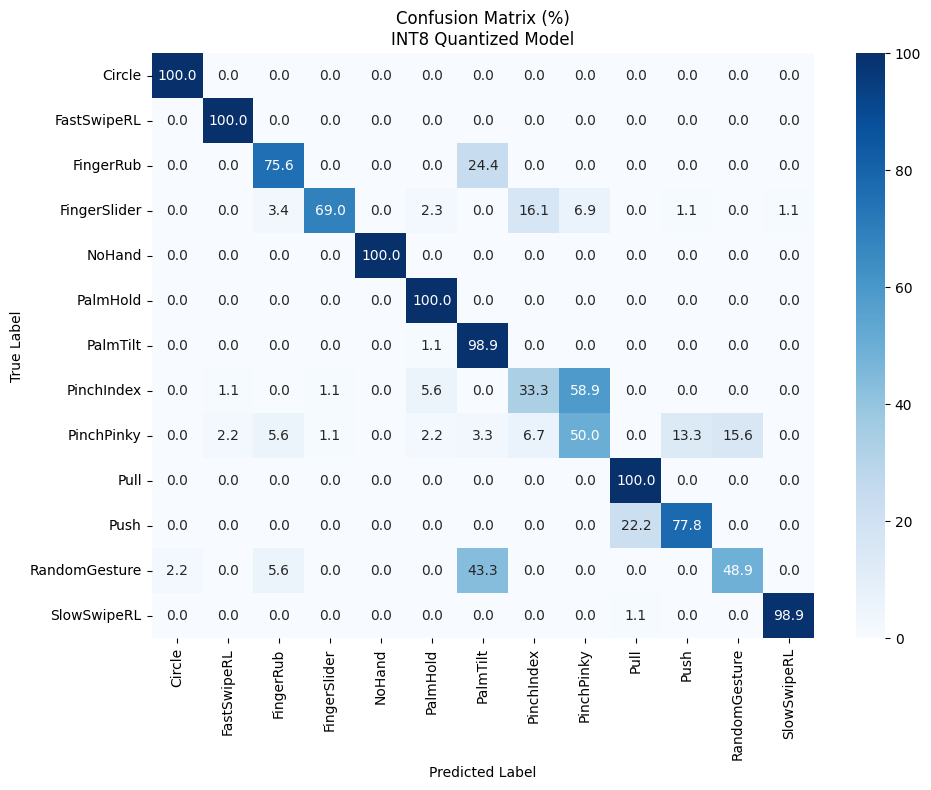


Classification Report:
               precision    recall  f1-score   support

       Circle     0.9783    1.0000    0.9890        90
  FastSwipeRL     0.9677    1.0000    0.9836        90
    FingerRub     0.8395    0.7556    0.7953        90
 FingerSlider     0.9677    0.6897    0.8054        87
       NoHand     1.0000    1.0000    1.0000        90
     PalmHold     0.8990    1.0000    0.9468        89
     PalmTilt     0.5817    0.9889    0.7325        90
   PinchIndex     0.6000    0.3333    0.4286        90
   PinchPinky     0.4327    0.5000    0.4639        90
         Pull     0.8108    1.0000    0.8955        90
         Push     0.8434    0.7778    0.8092        90
RandomGesture     0.7586    0.4889    0.5946        90
  SlowSwipeRL     0.9889    0.9889    0.9889        90

     accuracy                         0.8096      1166
    macro avg     0.8206    0.8095    0.8026      1166
 weighted avg     0.8202    0.8096    0.8024      1166



In [28]:
plot_confusion_matrix(y_true, y_pred, label_map, title_suffix="INT8 Quantized Model")
print_classification_report(y_true, y_pred, label_map)

In [ ]:
def parse_and_generate_cpp_int(input_path, output_path, var_name="input_data", int_type="int32_t"):
    input_values = []

    # Read and parse first 6 lines as integers
    with open(input_path, 'r') as f:
        for _ in range(6):
            line = f.readline()
            if not line:
                break
            values = [int(float(val)) for val in line.strip().split()]
            input_values.extend(values)

    # Write to .cpp file
    with open(output_path, 'w') as cpp_file:
        cpp_file.write('#include <cstddef>\n')
        cpp_file.write(f'#include <cstdint>\n\n')
        cpp_file.write(f'const size_t {var_name}_len = {len(input_values)};\n')
        cpp_file.write(f'const {int_type} {var_name}[] = {{\n')

        for i, val in enumerate(input_values):
            cpp_file.write(f'  {val},')
            if (i + 1) % 10 == 0:
                cpp_file.write('\n')
        cpp_file.write('\n};\n')

    print(f" Generated {output_path} with {len(input_values)} values of type {int_type}.")

# Example usage:
parse_and_generate_cpp_int(r'\Code\model_training\validation_inputs_var_3CNN.txt', 'test_data.cpp', var_name='g_test_image_data')

 Generated test_data.cpp with 30720 values of type int32_t.
